# An analysis regarding the prediction of precipitation amount in Seattle provided by an Atmospheric Scientist

## Objective:

- The customer would like to know the predicted precipitation amount on a specific day by using MLAs.

- The input dataset (seattleWeather_1948-2017.csv) provides information on a few Meteorological variables in Seattle from 1948 to 2017. 

- The input variables (predictors) are: Date, RAIN, TMAX, and TMIN. The last three are numerical continuous variables. RAIN is boolean.

- The outcome or dependent variable is: PRCP (continuous)

- In part 1 and part 2, I predicted the likelihood of whether it rains or not using feature engineering and the MLAs hyperparameters tuning, and achieved an accuracy score of 83%.

- Here, (part 3), I will examine the precipitation amount forecast which is much more challenging.
 

### Importing important libraries:

In [90]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb
import os

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing

from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression


### Reading the data:

In [2]:
met_df = pd.read_csv('/kaggle/input/did-it-rain-in-seattle-19482017/seattleWeather_1948-2017.csv')
print(met_df.head()); print(); print()
met_df.info()

         DATE  PRCP  TMAX  TMIN  RAIN
0  1948-01-01  0.47    51    42  True
1  1948-01-02  0.59    45    36  True
2  1948-01-03  0.42    45    35  True
3  1948-01-04  0.31    45    34  True
4  1948-01-05  0.17    45    32  True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25551 entries, 0 to 25550
Data columns (total 5 columns):
DATE    25551 non-null object
PRCP    25548 non-null float64
TMAX    25551 non-null int64
TMIN    25551 non-null int64
RAIN    25548 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 998.2+ KB


The description and unit of each variable:
- DATE = the date of the observation
- PRCP = the amount of precipitation, in inches
- TMAX = the maximum temperature for that day, in degrees Fahrenheit
- TMIN = the minimum temperature for that day, in degrees Fahrenheit
- RAIN = TRUE if rain was observed on that day, FALSE if it was not

## Data Cleaing:

### Step 1: Correcting wrong values or outliers:

In [3]:
met_df.describe(include = 'all')

,DATE,PRCP,TMAX,TMIN,RAIN
count,25551,25548.000000,25551.000000,25551.000000,25548
unique,25551,NaN,NaN,NaN,2
top,1981-10-05,NaN,NaN,NaN,False
freq,1,NaN,NaN,NaN,14648
mean,NaN,0.106222,59.544206,44.514226,NaN
std,NaN,0.239031,12.772984,8.892836,NaN
min,NaN,0.000000,4.000000,0.000000,NaN
25%,NaN,0.000000,50.000000,38.000000,NaN
50%,NaN,0.000000,58.000000,45.000000,NaN
75%,NaN,0.100000,69.000000,52.000000,NaN


The data description makes sense, and the mean, min, and max values of each variable are reasonable, meaning there should not be a mistake in the data (such as a very large temperature of 200 F).

### Step 2: Imputing missing values (necessary for linear regression):

There are only three missing data points for each PRCP and RAIN. So, we use median for PRCP to fill in the gaps.

In [91]:
met_df.isna().sum()

DATE    0
PRCP    0
TMAX    0
TMIN    0
RAIN    0
dtype: int64

In [92]:
P_median = met_df.PRCP.median()
met_df.PRCP.fillna(P_median, inplace = True)
met_df.isna().sum()

DATE    0
PRCP    0
TMAX    0
TMIN    0
RAIN    0
dtype: int64

### Step 3: Dropping binary (boolean) variable (necessary for linear regression):
- The outcome is continuous, so we drop RAIN which is binary.

In [6]:
met_df.drop('RAIN', axis=1)

,DATE,PRCP,TMAX,TMIN
0,1948-01-01,0.47,51,42
1,1948-01-02,0.59,45,36
2,1948-01-03,0.42,45,35
3,1948-01-04,0.31,45,34
4,1948-01-05,0.17,45,32
...,...,...,...,...
25546,2017-12-10,0.00,49,34
25547,2017-12-11,0.00,49,29
25548,2017-12-12,0.00,46,32
25549,2017-12-13,0.00,48,34


### Step 4: Change DATE variable to datetime format:

In [7]:
date = pd.to_datetime(met_df.DATE, format="%Y-%m-%d")
met_df['DATE'] = date
met_df.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


### Step 5: feature engineering:

- As seen in previous parts, precipitation amount and temperature are poorly correlated, but we extract new features from those two that will likely have a much higher correlation.

- Imagine today is 4 Jan. 2018. We can expect that the PRCP is close to the average PRCP on 4 Jan. in all previous years. So, we calculate a new variable: daily_PRCP (average PRCP on a specific day for all years).

- Similarly, we calculate other new variables: daily_TMAX (average TMAX on a specific day for all years) and daily_TMIN. We hope that daily_PRCP would be highly correlated with daily_TMAX and daily_TMIN.

In [8]:
## daily TMAX
from datetime import datetime
DoY_str = met_df.DATE.dt.strftime('%j')
Day_of_Year = [int(a) for a in DoY_str]
#group data based on "day of year"
groupD      = met_df.groupby(Day_of_Year)
DoY_TMAX   = groupD['TMAX'].mean()  # daily climatological mean TMAX
daily_TMAX = [DoY_TMAX[a] for a in Day_of_Year]

## daily TMIN
DoY_TMIN   = groupD['TMIN'].mean()  # daily climatological mean TMIN
daily_TMIN = [DoY_TMIN[a] for a in Day_of_Year]


## daily PRCP
#group data based on "day of year"
DoY_PRCP   = groupD['PRCP'].mean()  # daily climatological mean PRCP
daily_PRCP = [DoY_PRCP[a] for a in Day_of_Year]

In [23]:
# Add all these new variables to DataFrame:
daily_PRCP_df  = pd.DataFrame(daily_PRCP,  columns = ['daily_PRCP'])
daily_TMAX_df  = pd.DataFrame(daily_TMAX,  columns = ['daily_TMAX'])
daily_TMIN_df  = pd.DataFrame(daily_TMIN,  columns = ['daily_TMIN'])

met_new_df = pd.concat([met_df['DATE'],met_df['PRCP'],met_df['TMAX'],met_df['TMIN'],
                        daily_TMAX_df,daily_TMIN_df,daily_PRCP_df], axis = 1)

met_new_df.describe(include = 'all')

,DATE,PRCP,TMAX,TMIN,daily_TMAX,daily_TMIN,daily_PRCP
count,25551,25551.000000,25551.000000,25551.000000,25551.000000,25551.000000,25551.000000
unique,25551,NaN,NaN,NaN,NaN,NaN,NaN
top,1968-11-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
first,1948-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2017-12-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.106209,59.544206,44.514226,59.544206,44.514226,0.106209
std,NaN,0.239020,12.772984,8.892836,10.914882,7.333771,0.066588
min,NaN,0.000000,4.000000,0.000000,42.388889,32.888889,0.002857
25%,NaN,0.000000,50.000000,38.000000,49.300000,37.414286,0.049286


## Exploratory Data Analysis

We will verify that Linear Regression assumptions are met:
- All variables are continuous numeric, and not categorical.
- Data is free of outliers and missing values.
- A linear relationship exists between each predictor and the response.
- All predictors are independent of each other.

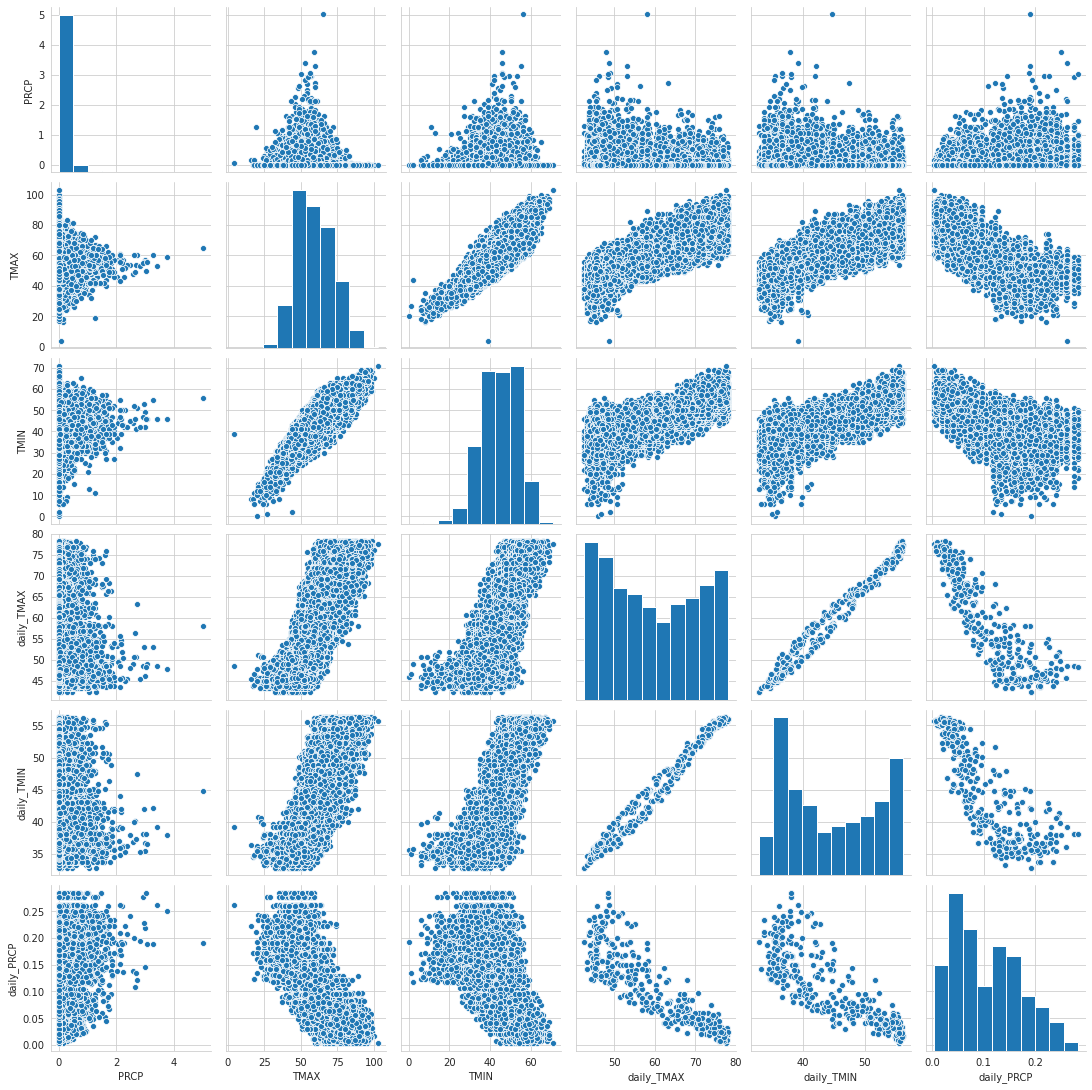

In [24]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

sb.pairplot(met_new_df, palette = 'husl')
plt.show()

By looking at the distribution of variables in the above pair-plots, we can say that all the variables are continuous numeric (necessary for linear regression).

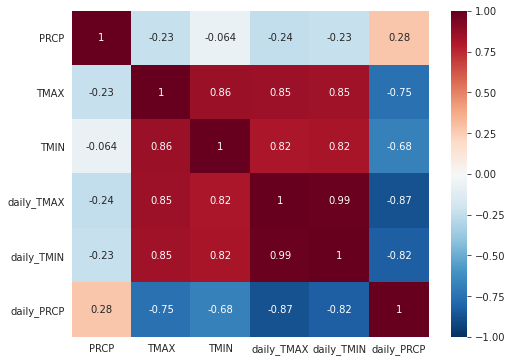

In [25]:
rcParams['figure.figsize'] = 8, 6
sb.heatmap(met_new_df.corr(), vmin=-1, vmax=1, annot=True, cmap = 'RdBu_r')
plt.show()

- The new variabels extracted via feature engineering appear to be very useful.
- Unlike very low correlation between PRCP and TMAX (or TMIN), daily_PRCP is highly correlated with daily_TMAX and daily_TMIN.
- We should also note that daily_TMAX, daily_TMIN, TMAX, and TMIN are highly correlated. So, we need to drop all but one of them, because features should be independent of each other in linear regression.

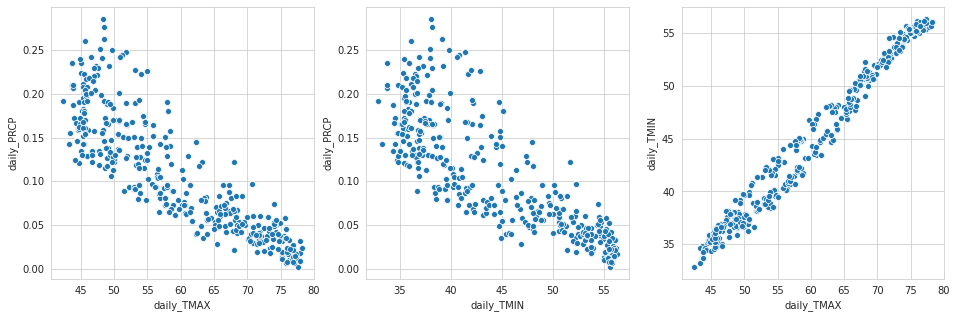

In [29]:
fig, axis = plt.subplots(1, 3,figsize=(16,5))
sb.scatterplot(x = 'daily_TMAX', y ='daily_PRCP', data = met_new_df, ax = axis[0])
sb.scatterplot(x = 'daily_TMIN', y ='daily_PRCP', data = met_new_df, ax = axis[1])
sb.scatterplot(x = 'daily_TMAX', y ='daily_TMIN', data = met_new_df, ax = axis[2])
plt.show()

- By looking at left and middle panels, we can verify that definitely there is a linear relationship between daily_TMAX and daily_PRCP, and between daily_TMIN and daily_PRCP. Also, there is no ovious outlier in both panels.

- As expected, daily_TMAX and daily_TMIN are not independent: this means that there are factors such as season, weather systems and sky cloudiness that affect both of them. We will drop daily_TMIN, because it is not independent of daily_TMAX, and it also has lower correlation with daily_PRCP.

----
The relationships among daily_TMAX, daily_TMIN and daily_PRCP can be understood as seasonal cycle of weather and climate. It is shown in the below plot. But we don't use the variable "day of year" in the Linear Regression model, because its relation with other variables is not linear, and the linear correlation between "day of year" and each of the three variables is very low.

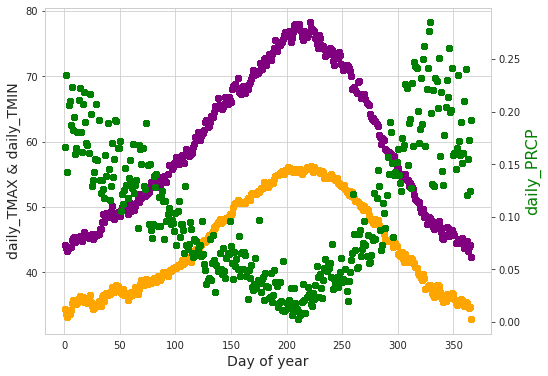

In [30]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()
ax1.scatter(Day_of_Year, daily_TMAX, c='purple')
ax1.scatter(Day_of_Year, daily_TMIN, c='orange')
ax2.scatter(Day_of_Year, daily_PRCP, c='g')
plt.grid(False)
ax1.set_xlabel('Day of year', fontsize=14)
ax1.set_ylabel('daily_TMAX & daily_TMIN', fontsize=14)
ax2.set_ylabel('daily_PRCP', fontsize=16, c='g')

plt.show()


---
We keep daily_TMAX as predictor and daily_PRCP as outcome. Other variables should be dropped:

In [14]:
met_new_df.drop(['DATE','PRCP','TMIN','TMAX','daily_TMIN'], inplace = True, axis=1)
met_new_df.head()

,daily_TMAX,daily_PRCP
0,44.271429,0.166571
1,43.714286,0.234571
2,43.300000,0.142143
3,43.785714,0.206571
4,43.842857,0.210429


## Implementing the linear regression model:


### Spliting the data into test and train sets:

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(met_new_df['daily_TMAX'].values.reshape(-1, 1),
                                                   met_new_df['daily_PRCP'], test_size=0.2, random_state=10)                             


### Linear Regression Model:

In [16]:
Lin_Reg = LinearRegression()
Lin_Reg.fit(X_train, Y_train)
R_squared_train = Lin_Reg.score(X_train, Y_train)
print(R_squared_train)

0.759369313397446


- The score vlaue is the R square of the prediction. It's a measure of how well the prediction from our linear regression model actually matches the real values.

- Let's retrieve coefficient and intercept of our linear model:

In [17]:
Lin_Reg.coef_[0], Lin_Reg.intercept_

(-0.005332443710527972, 0.42388583643626593)

The equation for linear regression:

daily_PRCP = daily_TMAX * LinReg.coef[0] + LinReg.intercept_

We plot our regression model and see how it fits the train dataset:

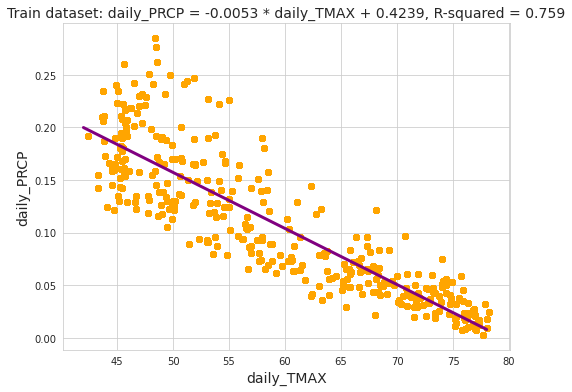

In [18]:
T = np.array(range(42,79))
P = Lin_Reg.coef_[0] *  T + Lin_Reg.intercept_

fig, ax1 = plt.subplots(figsize=(8, 6))
plt.plot(T, P, color = 'purple', lw = 3)
plt.scatter(X_train, Y_train, c = 'orange')

ax1.set_xlabel('daily_TMAX', fontsize=14)
ax1.set_ylabel('daily_PRCP', fontsize=14)

TITLE1 = 'Train dataset: daily_PRCP = %.4f'% Lin_Reg.coef_
TITLE2 = ' * daily_TMAX + %.4f, ' %Lin_Reg.intercept_
TITLE3 = 'R-squared = %.3f'% R_squared_train
TITLE = TITLE1 + TITLE2 + TITLE3
ax1.set_title(TITLE, fontsize=14)
plt.show()

## Model Validation:

We would like to see how our model predicts the test dataset:

In [19]:
R_squared_test = Lin_Reg.score(X_test, Y_test)
print(R_squared_test)

0.7648342082898617


- So, this model has a score value of 77% for test dataset, meaning that it can predict daily_PRCP from daily_TMAX correctly in 77% of the times for test dataset.

- We explore the prediction by plotting predicted daily_PRCP vs. test daily_PRCP:

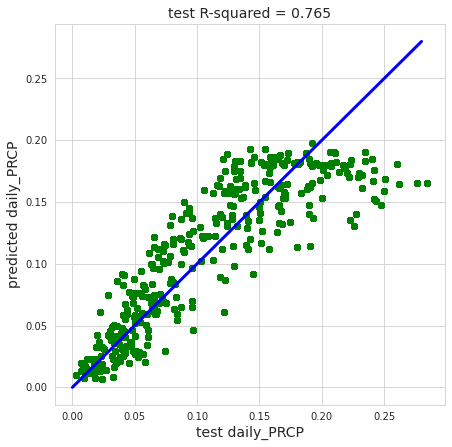

In [33]:
Y_pred = Lin_Reg.predict(X_test)

T = [0, 0.1, 0.2, 0.28]

fig, ax1 = plt.subplots(figsize=(7, 7))
plt.plot(T, T, color = 'b', lw = 3)
plt.scatter(Y_test, Y_pred, c = 'g')

ax1.set_xlabel('test daily_PRCP', fontsize=14)
ax1.set_ylabel('predicted daily_PRCP', fontsize=14)

TITLE = 'test R-squared = %.3f'% R_squared_test
ax1.set_title(TITLE, fontsize=14)
plt.show()

- So it seems that the model works well for low values of daily_PRCP. However, when daily_PRCP is greater than 0.2 in., the model under-predict daily_PRCP. This means that daily_TMAX might not be very good at predicting daily_PRCP for high values of daily_PRCP.
- This is due to the nature of weather processes: TMAX is more dependent of cloudiness, but the higher amount of precipitation does not really affect TMAX.
- Note that we will not use nonlinear models, because our data does not show nonlinear pattern. The use of nonlinear models in this case would lead to over-fitting problem.

### K-fold cross-validation

We use this validation to make sure the accuracy score is not dependent on the train-test split. In other words, we want to verify that the train-test split is random.

In [86]:
CV_scores = cross_val_score(Lin_Reg.fit(X_train, Y_train), X_test, Y_test, cv=5)
print ('5-fold cross-validation: scores = ')
print(CV_scores)

5-fold cross-validation: scores = 
[0.75155808 0.77449323 0.76711195 0.76470128 0.76635396]


- So, the scores from cross-validation do not vary much, and range between 0.752 and 0.774

In [85]:
CV_prediction = cross_val_predict(Lin_Reg.fit(X_train, Y_train), X_test, Y_test, cv=5)
CV_R_squared = metrics.r2_score(Y_test, CV_prediction)
CV_R_squared

0.7649132733336818

The cross-validation determines that the model can predict correctly in 76% of the times.

## Discussion:

- By using the Linear Regression Model, we reach an accuracy score of 76.5%, which means that our model at best can predict precipitation amount correctly in 76.5% of times for the test dataset.

- Using cross-validation, we showed that our results are independent of the train-test split.
further enhancement of score needs more features and more data.

- Note that I dropped the variable 'RAIN' to avoid high accuracy that would be wrong and misleading: 'RAIN' and 'PRCP' are strongly related.
----

### Future Work:
In the future, I will use additional features (variables such as wind, pressure, El Nino index, Atmospheric River index, and so on), use data for a longer time range, and employ more feature engineering to improve the prediction.